# Import libraries

In [1]:
import pathlib
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Read data from file

In [112]:
path = pathlib.Path('D:\Data Science\Real-Time-Data-Analysis\data\\raw\data-v4.csv')

df = pd.read_csv(path,index_col='index',parse_dates=True)

# Looking into data

In [113]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
index,,,,,,
2022-11-22 11:30:00,19.295000,19.295,19.254999,19.270000,19.270000,442403
2022-11-22 12:30:00,19.275000,19.330,19.260000,19.325001,19.325001,332026
2022-11-22 13:30:00,19.330000,19.385,19.320000,19.353901,19.353901,297977
2022-11-22 14:30:00,19.360001,19.400,19.355000,19.395000,19.395000,454029
2022-11-22 15:30:00,19.395000,19.410,19.360001,19.375000,19.375000,881313


In [114]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1.761000e+03
mean,20.691314,20.762139,20.624997,20.694528,20.694528,1.175075e+06
std,2.572526,2.580969,2.563817,2.571897,2.571897,9.197879e+05
min,16.424999,16.545000,16.389999,16.424999,16.424999,0.000000e+00
25%,18.549999,18.620001,18.490000,18.559999,18.559999,5.762140e+05
50%,19.889999,19.969999,19.820000,19.879999,19.879999,8.836510e+05
75%,22.920000,23.014999,22.820000,22.910000,22.910000,1.480424e+06
max,26.225000,26.389999,26.190001,26.225000,26.225000,8.628966e+06


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2021-11-23 09:30:00 to 2022-11-22 15:30:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1761 non-null   float64
 1   High       1761 non-null   float64
 2   Low        1761 non-null   float64
 3   Close      1761 non-null   float64
 4   Adj Close  1761 non-null   float64
 5   Volume     1761 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 96.3 KB


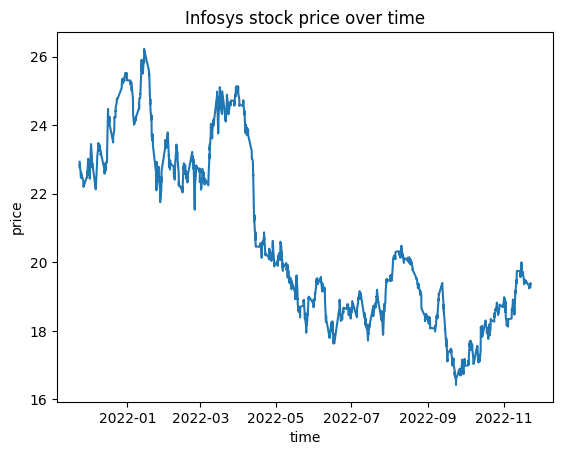

In [116]:
plt.plot(df.index, df["Close"])
plt.title("Infosys stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

# Find p, d, and q values for ARIMA model 

Before building the ARIMA model, let’s see if there is some cross-correlation in out data.

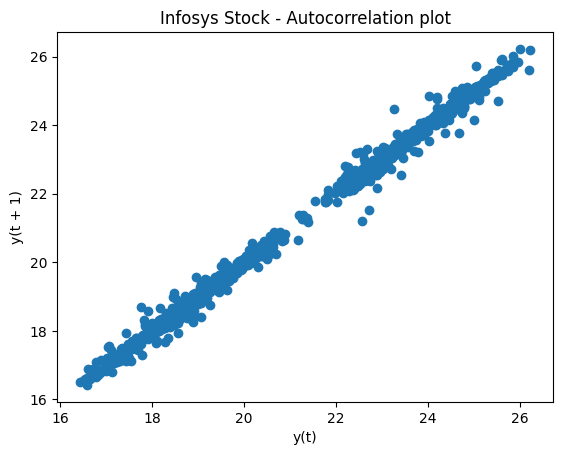

In [117]:
lag_plot(df['Close'], lag=1)
plt.title('Infosys Stock - Autocorrelation plot')
plt.show()

p is order of Autoregrassion <br>
d is order of differencing requiredd to make time series stationary <br>
q is order Moving aaverages

## Stationarity

Substract current value from previous value. We need to do diffenting peration multiple times to make series stationary. <br>
Select minimun value for ARIMA model.

### ADF test

We will use Augumented Dickey Fuller (ADF) test check stationarity in series. <br>
<br>
Null hypothesis of ADF test is that time series is non-stationary. If p-value of test is less than 0.05 then wee can reject null hypothesis. <br>
So, if p-value > 0.05 we'll find order of diffencing.  

In [118]:
from statsmodels.tsa.stattools import adfuller

In [119]:
dftest = adfuller(df['Close'],autolag='AIC')
print('1. ADF statistic :',dftest[0])
print('2. P-value :',dftest[1])

1. ADF statistic : -1.3371494856281014
2. P-value : 0.6120097308800951


## ## We find our series is non-stationary.

In [120]:
# from pmdarima import auto_arima
# import warnings
# warnings.filterwarnings('ignore')

## Autocorrelation Function (ACF) Plot

In [121]:
from statsmodels.graphics.tsaplots import plot_acf

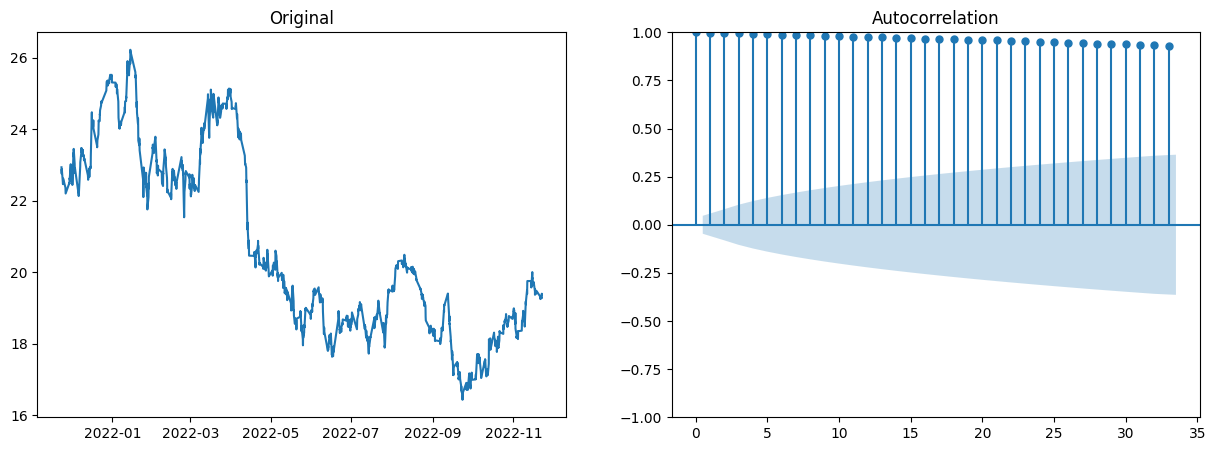

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(df['Close'])
ax1.set_title('Original')
plot_acf(df['Close'], ax=ax2);

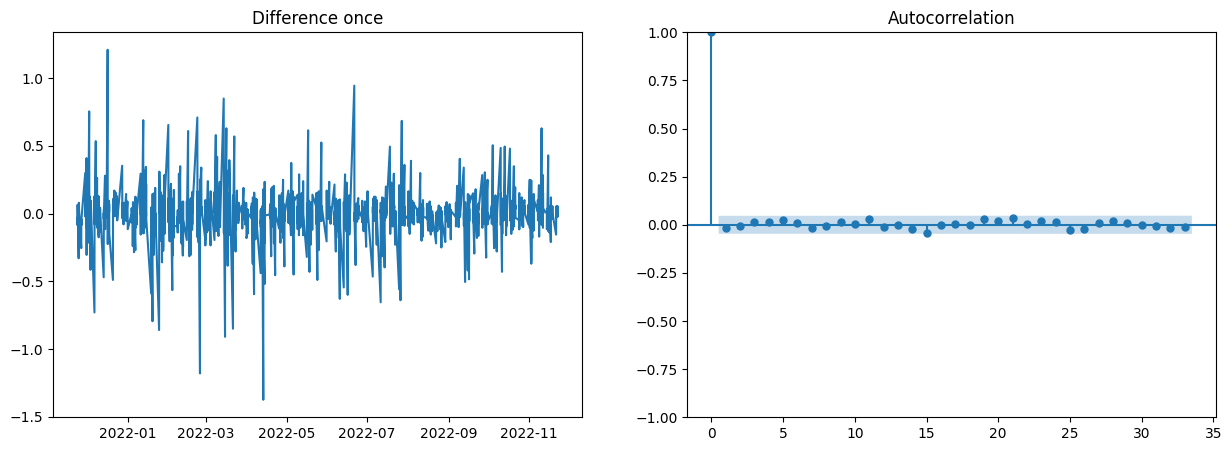

In [144]:
diff = df['Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

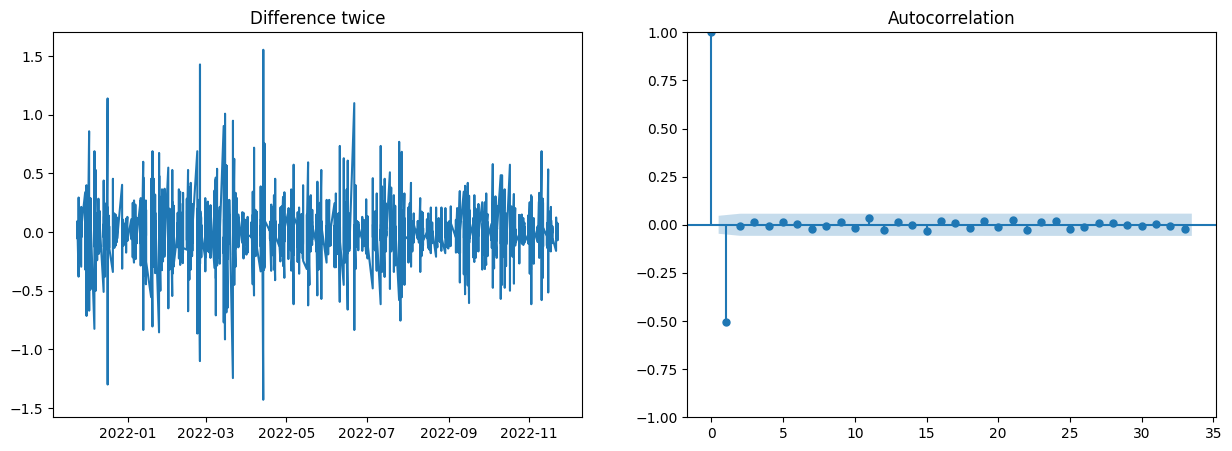

In [145]:
diff = df['Close'].diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

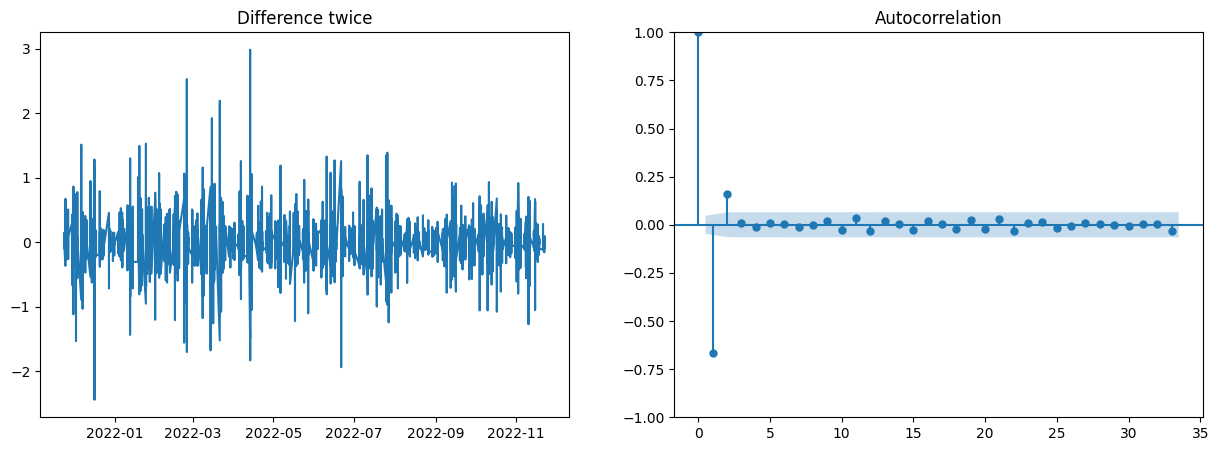

In [146]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

## ## Here we find diffence order 3 is good.

Because there is gives positive value in third order differencing.

# p

p is the order of Auto regression (AR). It refers to number of lags to be used ass predictors. <br>
We can find required number of AR terms by inspecting Partial Autocorrelation (PACF) plot. <br>
The Partial Autocorrelation represents correlation between series and it's lags.

In [147]:
from statsmodels.graphics.tsaplots import plot_pacf

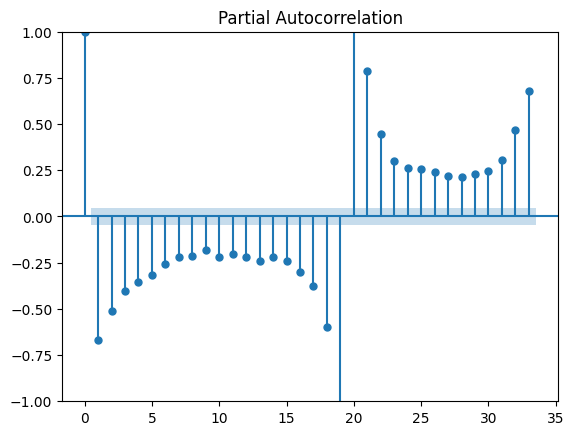

In [179]:
diff = df['Close'].diff().diff().diff().dropna()

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# ax1.plot(diff)
# ax1.set_title('Difference once')
p = plot_pacf(diff);

In [185]:
# statsmodels.tsa.stattools.pacf
from statsmodels.tsa.stattools import pacf
diff = df['Close'].diff().diff().diff().dropna()
print(pacf(diff))

[ 1.         -0.6671859  -0.51074527 -0.40473439 -0.35187775 -0.3144978
 -0.25778622 -0.21665588 -0.21394752 -0.18373007 -0.21822233 -0.20100202
 -0.22169959 -0.24259458 -0.21764278 -0.24193998 -0.30260665 -0.37483169
 -0.59795684 -1.41902139  3.43886532  0.784523    0.4475736   0.30109528
  0.26135173  0.25493475  0.24010834  0.2180563   0.21180792  0.23031276
  0.24829645  0.30827915  0.46687918]


In [187]:
from statsmodels.tsa.stattools import acf
diff = df['Close'].diff().diff().diff().dropna()
print(acf(diff))

[ 1.         -0.66680638  0.16155937  0.01172302 -0.0134658   0.00937875
  0.0061947  -0.01338113 -0.00199673  0.01799056 -0.0284142   0.0369871
 -0.03362497  0.01926423  0.00495638 -0.02653855  0.01951486  0.0051552
 -0.0209242   0.0231298  -0.02375199  0.03075701 -0.03087122  0.01163789
  0.01479569 -0.01667633 -0.00382912  0.00693078  0.00388485 -0.00235646
 -0.00387617  0.00601101  0.00158184]


d:\Data Science\Real-Time-Data-Analysis\myenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


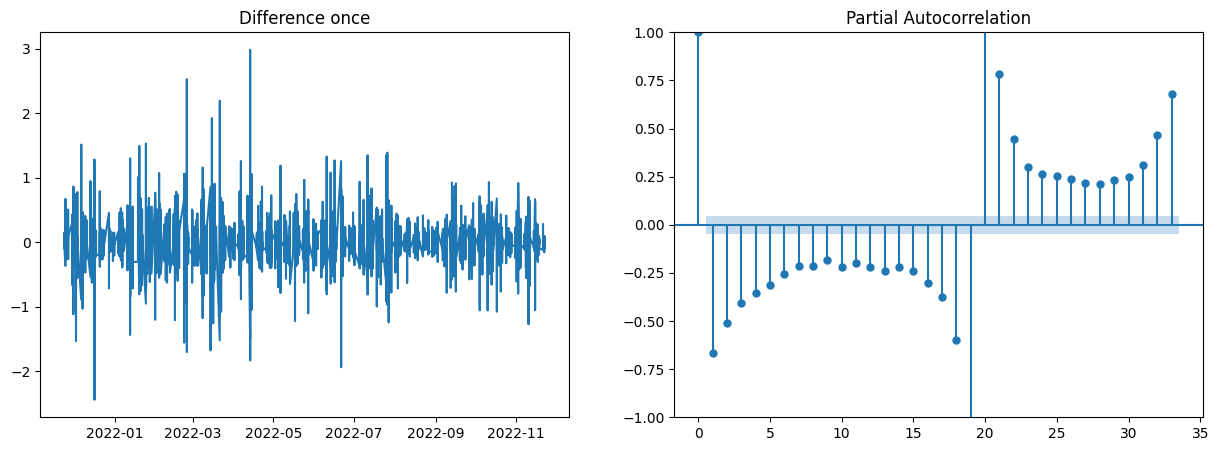

In [148]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_pacf(diff, ax=ax2);

## ## 20 is the positive value for Auto regression

# q

q is the order of moving average (MA). It refers to number of laged forecast erros that should be go into the ARIMA. <br>
We can look at ACF plot for number of MA term.

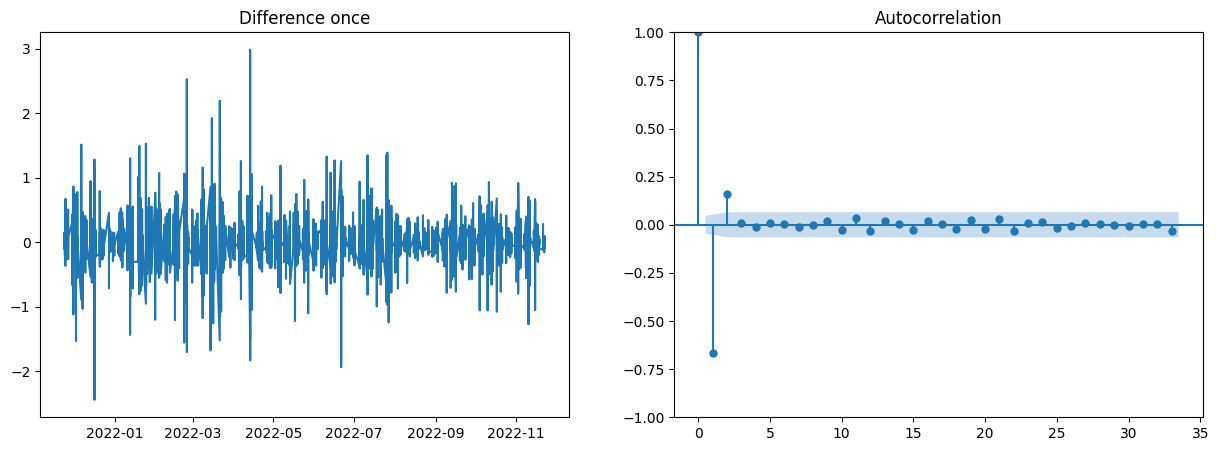

In [149]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

## ## We find that 2 is no order for MA

In [150]:
# stepswise_fit = auto_arima(df['Close'], trace=True, suppress_warnings=True)
# stepswise_fit.summary()

# Let's build model

In [151]:
# train_data, test_data = df[0:int(len(df)*0.9)], df[int(len(df)*0.9):]

# training_data = train_data['Close'].values
# test_data = test_data['Close'].values

# history = [x for x in training_data]
# model_predictions = []
# N_test_observations = len(test_data)

# residuals = 0

# for time_point in range(N_test_observations):
#     model = ARIMA(history, order=(20,3,2))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat = output[0]
#     model_predictions.append(yhat)
#     true_test_value = test_data[time_point]
#     history.append(true_test_value)

#     residuals = pd.DataFrame(model_fit.resid)
    
# MSE_error = mean_squared_error(test_data, model_predictions)
# print('Testing Mean Squared Error is {}'.format(MSE_error))

In [152]:
# residuals = residuals[1:]

In [153]:
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

In [154]:
# test_set_range = df[int(len(df)*0.7):]
# plt.plot(test_set_range.index, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
# plt.plot(test_set_range.index, test_data, color='red', label='Actual Price')
# plt.title('Infosys Prices Prediction')
# plt.xlabel('Date')
# plt.ylabel('Prices')
# plt.legend()
# plt.show()

In [155]:
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume
index,,,,,,
2022-11-21 13:30:00,19.295000,19.320000,19.270000,19.275000,19.275000,359113
2022-11-21 14:30:00,19.270800,19.280001,19.245001,19.245001,19.245001,526941
2022-11-21 15:30:00,19.245001,19.309999,19.240000,19.299999,19.299999,802208
2022-11-22 09:30:00,19.280001,19.350000,19.280001,19.285000,19.285000,1016177
2022-11-22 10:30:00,19.280001,19.330000,19.275000,19.290001,19.290001,544681
2022-11-22 11:30:00,19.295000,19.295000,19.254999,19.270000,19.270000,442403
2022-11-22 12:30:00,19.275000,19.330000,19.260000,19.325001,19.325001,332026
2022-11-22 13:30:00,19.330000,19.385000,19.320000,19.353901,19.353901,297977
2022-11-22 14:30:00,19.360001,19.400000,19.355000,19.395000,19.395000,454029


In [156]:
future_index = pd.date_range(start='2022-11-18 09:30:00', end='2022-11-19 03:30:00', freq='1H')

In [157]:
future_index[:10]

DatetimeIndex(['2022-11-18 09:30:00', '2022-11-18 10:30:00',
               '2022-11-18 11:30:00', '2022-11-18 12:30:00',
               '2022-11-18 13:30:00', '2022-11-18 14:30:00',
               '2022-11-18 15:30:00', '2022-11-18 16:30:00',
               '2022-11-18 17:30:00', '2022-11-18 18:30:00'],
              dtype='datetime64[ns]', freq='H')

In [158]:
print(len(future_index))

19


In [171]:
history = [x for x in df['Close'].values]

modelF = ARIMA(history, order=(20,3,2))
model_Fit = modelF.fit()

output = model_Fit.forecast(steps=19)

d:\Data Science\Real-Time-Data-Analysis\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [172]:
output

array([19.37332349, 19.38622163, 19.38841674, 19.39339481, 19.38761305,
       19.38243409, 19.37236656, 19.37547019, 19.37981424, 19.38656592,
       19.38737115, 19.390381  , 19.39574921, 19.40016842, 19.40616758,
       19.41396447, 19.42147647, 19.42911479, 19.43269729])

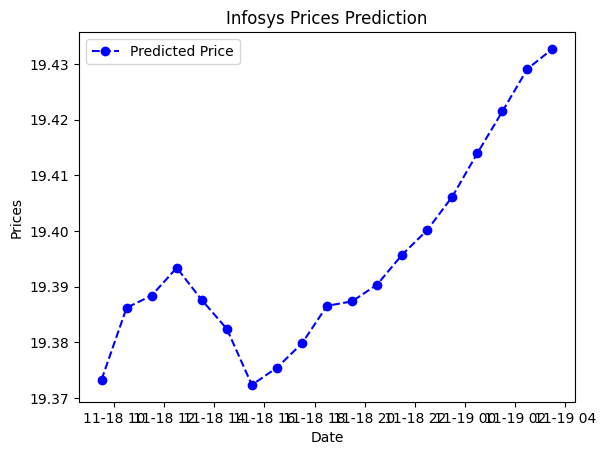

In [173]:
plt.plot(future_index, output, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.title('Infosys Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

1,2,1 and 0,1,0